Final Project Presentation
===============

In [1]:
import sqlite3
import pathlib
from contextlib import closing

import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
DATA_DIR = pathlib.Path('/') / 'data' / 'declanvk'
VARIABLE_DIR = DATA_DIR / 'training_log' / 'variable_save'
DB_PATH = DATA_DIR / 'netflix_prize.sqlite'

DB_RATING_QUERY = """
SELECT
  rating.item_id AS ItemID,
  rating.customer_id AS CustomerID,
  rating.value AS Rating,
  rating.day AS Day,
  freq AS Freq
FROM rating
  INNER JOIN customer_time_freq
    ON (
    customer_time_freq.customer_id = rating.customer_id AND
    customer_time_freq.day = rating.day)
WHERE model_group_id IN ({});
"""

NUM_BINS = 30
DRIFT_BETA = 0.4

NUM_MODEL_GROUPS = 1000000

COLUMN_TYPES = [np.int32, np.int32, np.float32, np.int32, np.int32]

In [3]:
with sqlite3.connect(str(DB_PATH)) as connection, closing(connection.cursor()) as curs:
    curs.execute('SELECT count(*) FROM item')
    num_items, = curs.fetchone()
    curs.execute('SELECT count(*) FROM rating')
    num_ratings, = curs.fetchone()
    curs.execute('SELECT count(*) FROM customer')
    num_customers, = curs.fetchone()
    curs.execute('SELECT avg(value) FROM rating')
    avg_rating, = curs.fetchone()
    curs.execute('SELECT mean_day FROM customer ORDER BY customer_id ASC')
    mean_days = np.fromiter(map(lambda row: row[0], curs.fetchall()), dtype=np.float32)
    curs.execute('SELECT min(day), max(day) FROM rating')
    min_day, max_day = curs.fetchone()
    curs.execute('SELECT min(freq), max(freq) FROM customer_time_freq')
    min_freq, max_freq = curs.fetchone()
    min_log_freq, max_log_freq = list(map(lambda x: int(np.floor(np.log(x))), [min_freq, max_freq]))

In [4]:
item_time_binned_baseline = np.load(VARIABLE_DIR / 'item_time_binned_baseline.npy')
item_log_frequency_baseline = np.load(VARIABLE_DIR / 'item_log_frequency_baseline.npy')
item_baseline = np.load(VARIABLE_DIR / 'item_baseline.npy')
customer_multiplier = np.load(VARIABLE_DIR / 'customer_multiplier.npy')
customer_drift = np.load(VARIABLE_DIR / 'customer_drift.npy')
customer_baseline = np.load(VARIABLE_DIR / 'customer_baseline.npy')

In [5]:
def get_ratings(model_groups):
    query = DB_RATING_QUERY.format(",".join(map(str, model_groups)))
    with sqlite3.connect(str(DB_PATH)) as connection:
        data = pd.read_sql(query, connection)
        convert_pair = lambda pair: data[pair[1]].as_matrix().astype(COLUMN_TYPES[pair[0]])
        return list(map(convert_pair, enumerate(data)))

In [6]:
def predict_baseline_rating(item_ids, customer_ids, days, frequencies):
    assert item_ids.size == customer_ids.size == days.size == frequencies.size
    
    # Item binned time term
    binned_day_idx = (NUM_BINS * (days - min_day) / (max_day - min_day)).astype(np.int32)
    item_time_binned_baseline_subset = item_time_binned_baseline[item_ids, binned_day_idx]
    
    # Item frequency term
    floor_log_freq = np.floor(np.log(frequencies)).astype(np.int32)
    item_log_freq_baseline_subset = item_log_frequency_baseline[item_ids, floor_log_freq]
    
    # Item baseline term
    item_baseline_subset = item_baseline[item_ids]
    
    # Item term
    item_term = item_baseline_subset + item_time_binned_baseline_subset
    
    # Customer item multiplier term
    customer_multiplier_subset = customer_multiplier[customer_ids]
    
    # Customer drift term
    time_diff = days.astype(np.float32) - mean_days[customer_ids]
    customer_deviation = customer_drift[customer_ids] * np.sign(time_diff) * np.power(np.abs(time_diff), DRIFT_BETA)
    
    # Customer baseline term
    customer_baseline_subset = customer_baseline[customer_ids]
    
    # Customer term
    customer_term = customer_baseline_subset + customer_deviation
    
    return avg_rating + customer_term + item_term * customer_multiplier_subset + item_log_freq_baseline_subset

In [7]:
# Get rating data

model_group_ids = np.random.choice(NUM_MODEL_GROUPS, size=int(NUM_MODEL_GROUPS * 0.005), replace=False)

item_ids, customer_ids, ratings, days, frequencies = get_ratings(model_group_ids)

In [8]:
predicted_ratings = predict_baseline_rating(item_ids, customer_ids, days, frequencies)

(array([  9.89000000e+02,   1.27160000e+04,   2.52960000e+04,
          5.86620000e+04,   1.28288000e+05,   1.52139000e+05,
          1.00675000e+05,   2.51980000e+04,   2.50000000e+02,
          6.00000000e+00]),
 array([-3.75911903, -3.01806226, -2.27700548, -1.53594871, -0.79489193,
        -0.05383515,  0.68722162,  1.4282784 ,  2.16933517,  2.91039195,
         3.65144873]),
 <a list of 10 Patch objects>)

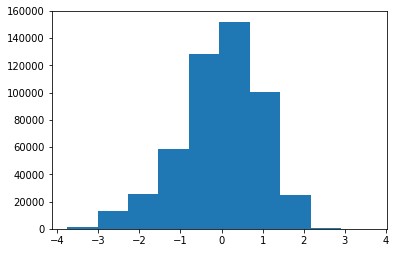

In [9]:
plt.hist(ratings - predicted_ratings)

In [ ]:
CONNECTION = sqlite3.connect(str(DB_PATH))